# Задачи

- Создать рекомендательную систему по курсам;
- Составить таблицу, где к каждому ID курса будут предоставлены ещё два курса, которые будут рекомендоваться.

In [1]:
# Загружаем необходимые в работе библиотеки
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
import matplotlib.pyplot as plt
%matplotlib inline


Используем функцию *getPurchaseCourses()*, чтобы выгрузить данные из метабазы SQL по всем продажам курсов в разрезе пользователей. 
Результат запишем в датафрейм **purchase_df** и получим таблицу с купленными курсами, каждым из пользователей учебной платформы. 

In [2]:
def getPurchaseCourses():
    query = '''
    select
    distinct f.user_id,
    ci.resource_id
from 
    final.carts f
join
    final.cart_items ci on f.id = ci.cart_id
where
    f.state = 'successful' and ci.resource_type = 'Course'
order by f.user_id
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

purchase_df = pd.DataFrame(getPurchaseCourses())
purchase_df

,user_id,resource_id
0,51,516
1,51,1099
2,974,356
3,2233,1125
4,2581,1187
...,...,...
70419,2190509,742
70420,2190575,757
70421,2190589,1125
70422,2190991,489


Сгруппируем пользователей таким образом, чтобы напротив каждого пользователя был список ID курсов, которые он приобрел. Запишем результат в переменную **users_purchase_list**.

In [3]:
users_purchase_list = purchase_df.groupby(['user_id'])['resource_id'].apply(lambda x: list(np.unique(x))).reset_index()
users_purchase_list

,user_id,resource_id
0,51,"[516, 1099]"
1,974,[356]
2,2233,[1125]
3,2581,[1187]
4,3480,[745]
...,...,...
49001,2190509,[742]
49002,2190575,[757]
49003,2190589,[1125]
49004,2190991,[489]


Далее, разбиваем списки ID курсов для каждого пользователя на все возможные комбинации купленных пар курсов. Данную операцию проделываем с помощью библиотеки *itertools* и метода *combinations*. Результат запишем в список **result_list**.

In [4]:
import itertools
result_list = list()
# проходим по спискам resource_id 
for courses in users_purchase_list['resource_id']:
    # проходим циклом по содержимому каждого списка с делением на пары
    for course_pair in itertools.combinations(courses, 2): 
        result_list.append(course_pair)

In [5]:
# просмотрим получившееся количество пар купленных курсов
len(result_list)

40017

Удалим дубликаты, записав результат во множество **result_set**.

In [6]:
result_set = set(result_list)
len(result_set)

3989

Посчитаем количество продаж каждой пары. Для этого воспользуемся библиотекой *collections*, в которой есть счетчик *Counter()*.

In [7]:
import collections
c = collections.Counter()
for pairs in result_list:
    c[pairs]+=1
print(c)

Counter({(551, 566): 797, (515, 551): 417, (489, 551): 311, (523, 551): 304, (566, 794): 290, (489, 515): 286, (490, 566): 253, (490, 551): 247, (570, 752): 247, (569, 572): 216, (515, 523): 213, (553, 745): 212, (489, 523): 206, (569, 840): 204, (514, 551): 200, (516, 745): 199, (515, 566): 195, (489, 566): 188})


Преобразуем наш счетчик "с" в словарь. В котором, в качестве ключа будет пара курсов, а в качестве значения - популярность пары (чем выше число, тем выше популярность и соответственно продажи этих пар).

In [8]:
dict_c = dict(c)
dict_c

{(516, 1099): 25,
 (356, 357): 100,
 (356, 1125): 44,
 (357, 1125): 52,
 (553, 1147): 16,
 (361, 1138): 40,
 (1125, 1140): 1,
 (551, 745): 138,
 (553, 745): 212,
 (551, 1138): 14,
 (553, 568): 83,
 (514, 517): 10,
 (514, 566): 138,
 (517, 566): 21,
 (363, 511): 99,
 (363, 562): 77,
 (363, 563): 33,
 (511, 562): 55,
 (511, 563): 19,
 (562, 563): 53,
 (568, 745): 102,
 (509, 553): 48,
 (509, 745): 59,
 (1125, 1144): 22,
 (509, 568): 46,
 (509, 672): 5,
 (568, 672): 4,
 (516, 552): 12,
 (356, 552): 7,
 (357, 571): 112,
 (509, 516): 35,
 ...}

Отсортируем получившийся словарь по парам ID курсов в порядке возрастания и запишем результат в словарь **sorted_pairs**.

In [9]:
sorted_pairs = {k: v for k, v in sorted(dict_c.items(), key=lambda item: item[0], reverse=False)}
sorted_pairs

{(356, 357): 100,
 (356, 360): 1,
 (356, 361): 17,
 (356, 366): 15,
 (356, 367): 12,
 (356, 368): 1,
 (356, 489): 26,
 (356, 490): 13,
 (356, 502): 17,
 (356, 503): 1,
 (356, 508): 1,
 (356, 509): 5,
 (356, 513): 1,
 (356, 514): 35,
 (356, 515): 21,
 (356, 516): 16,
 (356, 517): 3,
 (356, 519): 14,
 (356, 523): 24,
 (356, 551): 48,
 ...}

Создадим функцию *recommend*. Которая будет принимать на вход ID курса и выдавать нам список, содержащий 2 самые популярные пары с этим курсом.

In [10]:
def recommend(course):
    course_list = [] #создаем пустой список
    for i in sorted_pairs.keys(): #проходим циклом по ключам отсортированного словаря
        if i[0] == course or i[1] == course: # если первый или второй элемент пары курсов = ID курсу, который мы вводим на вход функции
            course_list.append((i, sorted_pairs[i])) # то добавляем в список кортеж, который состоит из пары курсов и их количества
    sorted_course_list = sorted(course_list, key=lambda x: x[1], reverse=True) # сортируем список в порядке убывания по количеству
    return sorted_course_list[:2] # выводим только 2 значения, в которых содержатся курсы для рекомендации №1 и №2

Проверим, как работает наша функция, введя курс "523".

In [11]:
recommend(523)

[((523, 551), 304), ((515, 523), 213)]

Мы получили два кортежа, которые содержат две самые популярные пары курсов и их количество. Итого, на примере курса с **ID = 523**, мы получаем рекомендации двух других курсов с **ID = 551 и 515**.

Далее создадим список всех курсов с их уникальными значениями и отсортируем в порядке возрастания.

In [12]:
list_of_courses = purchase_df['resource_id'].unique()
list_of_courses = sorted(list_of_courses)
print (list_of_courses)

[356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 489, 490, 502, 503, 504, 507, 508, 509, 511, 513, 514, 515, 516, 517, 518, 519, 523, 551, 552, 553, 562, 563, 564, 566, 568, 569, 570, 571, 572, 659, 664, 670, 671, 672, 679, 741, 742, 743, 744, 745, 749, 750, 752, 753, 755, 756, 757, 764, 765, 776, 777, 791, 794, 800, 803, 809, 810, 813, 814, 829, 830, 833, 834, 835, 836, 837, 840, 862, 863, 864, 865, 866, 902, 907, 908, 909, 911, 912, 1099, 1100, 1101, 1102, 1103, 1104, 1115, 1116, 1124, 1125, 1128, 1129, 1138, 1139, 1140, 1141, 1144, 1145, 1146, 1147, 1152, 1156, 1160, 1161, 1181, 1182, 1184, 1185, 1186, 1187, 1188, 1198, 1199, 1200, 1201]


Теперь всё готово, для создания датафрейма содержащего в себе ID каждого курса и две самые популярные пары курсов с их количеством.

In [13]:
recomendations_df = pd.DataFrame(columns = ['Рекомендация №1', 'Рекомендация №2'])
for i in list_of_courses:
        recomendations_df.loc[i] = [recommend(i)[0], recommend(i)[1]]
recomendations_df.index.name = 'Курс_ID'
recomendations_df

,Рекомендация №1,Рекомендация №2
Курс_ID,,
356,"((356, 571), 103)","((356, 357), 100)"
357,"((357, 571), 112)","((356, 357), 100)"
358,"((358, 570), 25)","((358, 752), 19)"
359,"((359, 570), 16)","((358, 359), 15)"
360,"((360, 745), 17)","((360, 516), 12)"
...,...,...
1188,"((1141, 1188), 15)","((513, 1188), 11)"
1198,"((571, 1198), 5)","((551, 1198), 3)"
1199,"((523, 1199), 2)","((359, 1199), 1)"


Импортируем получившийся датафрейм в таблицу excel.

In [14]:
recomendations_df.to_excel(r'recommendation_table.xlsx')

Итак, мы составили таблицу [https://drive.google.com/file/d/1hblMDLZpRY-RXCb31qqEaSOM8jpQrwsj/view?usp=sharing], которая ляжет в основу нашей рекомендательной системы к каждому доступному курсу на обучающей платформе. Используя эти данные, предлагаем ввести выбор пакетной оплаты курсов, для удобства пользователей. Помимо этого, для стимулирования большего числа покупок, можно создать скидочную или бонусную программу при покупке курсов в виде пакетов.

Помимо "точечной" рекомендации к каждому курсу. Предлагаем создать на платформе рекомендации, содержащие в себе 10 лучших продающихся и наиболее востребованных пар курсов. Подаваться это может, например, под предлогом изучить наиболее актуальные и популярные курсы в данный момент. Список можно сделать обновляемым с течением времени. 

In [15]:
course_list_1 = [] 
for i in sorted_pairs.keys(): 
    course_list_1.append((i, sorted_pairs[i])) 
sorted_course_list_1 = sorted(course_list_1, key=lambda x: x[1], reverse=True)
popular_df = pd.DataFrame(sorted_course_list_1[:10], columns = ['Пара курсов', 'Количество продаж'], index = [1,2,3,4,5,6,7,8,9,10])
popular_df.index.name = 'Топ-10'
popular_df

,Пара курсов,Количество продаж
Топ-10,,
1,"(551, 566)",797
2,"(515, 551)",417
3,"(489, 551)",311
4,"(523, 551)",304
5,"(566, 794)",290
6,"(489, 515)",286
7,"(490, 566)",253
8,"(490, 551)",247
9,"(570, 752)",247


Для наглядности отображения **Топ-10** используем график.

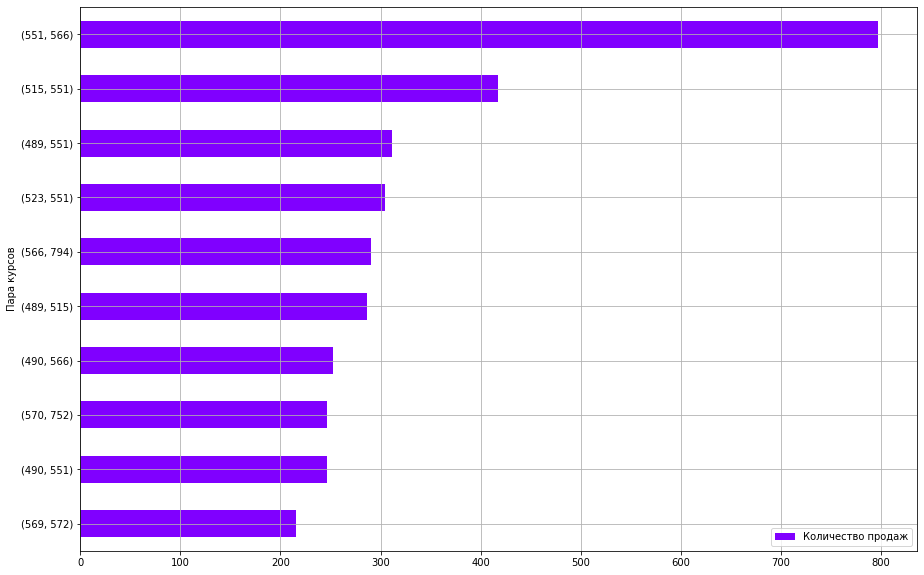

In [16]:
popular_df.groupby(by = ['Пара курсов']).sum().sort_values('Количество продаж').plot(kind = 'barh', grid= True, colormap = 'rainbow', figsize=(15, 10))

Итак, мы справились с поставленными задачами и создали рекомендательную систему по всем курсам. Теперь, мы сможем предлагать пользователям платформы только те курсы, которые заинтересуют их с наибольшей вероятностью!